## Question 1 - Predicting the winner

Firstly we need to import some modules to help us along the way.

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import poisson, skellam
import matplotlib.mlab as mlab
import math
from collections import Counter

Then we want to read the data file into our program.

In [30]:
data = pd.read_csv("resources/PremierLeague1718.csv") # Read the data set file

The data file consists of empty columns and rows which we want to clean up so that we are working with _clean_ data. To do this we can use the below function.

In [31]:
def clean(dataframe):
    assert isinstance(dataframe, pd.DataFrame), 'Argument of wrong type!'
    return dataframe.dropna(axis=1, how='all')

And then we can apply this to our data.

In [32]:
data = clean(data) # Clean the data up to remove empty and NaN cols

Because the data file consists of a lot of columns, some of them are irrelevant to us, the below function can help eliminate these columns, to do this we can specify only the columns we want to keep as a list of column names.

In [33]:
def filterCols(dataframe, cols):
    assert isinstance(dataframe, pd.DataFrame), 'Argument of wrong type!'
    assert isinstance(cols, list), 'Argument of wrong type!'
    return dataframe[cols]

We can then use this function to filter our data.

In [34]:
colsToKeep = ["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "HS", "AS", "HST", "AST", "FTR"] # List of cols we want to keep
data = filterCols(data, colsToKeep) # Filter relevant cols

To get an idea of how the data looks like, we can use the `describe` function to give us various information. (This is helpful to answer Question 1, part 1.)

In [35]:
print("Description:")
print(data.describe())

Description:
             FTHG        FTAG          HS          AS         HST         AST
count  240.000000  240.000000  240.000000  240.000000  240.000000  240.000000
mean     1.491667    1.183333   13.666667   11.141667    4.554167    3.791667
std      1.344419    1.250830    6.055301    5.110160    2.781661    2.385086
min      0.000000    0.000000    2.000000    1.000000    0.000000    0.000000
25%      0.000000    0.000000    9.000000    7.000000    2.750000    2.000000
50%      1.000000    1.000000   13.000000   10.000000    4.000000    3.500000
75%      2.000000    2.000000   17.000000   14.000000    6.000000    5.000000
max      7.000000    6.000000   35.000000   30.000000   15.000000   14.000000


Furthermore, we can also group the data in a way so that we can see an outlook of how many goals were scored and conceded by each team over the whole league.

In [36]:
def renameCols(df, colsdict):
    return df.reset_index().rename(columns=colsdict)

def creategroups():
    groups = [0,0,0,0]
    groups[0] = renameCols(data.groupby("HomeTeam")["FTR"].apply(lambda x: x[x == 'H'].count()), {"HomeTeam": "Team", "FTR": "Wins at home"})
    groups[1] = renameCols(data.groupby("AwayTeam")["FTR"].apply(lambda x: x[x == 'A'].count()), {"AwayTeam": "Team", "FTR": "Wins away"})
    groups[2] = renameCols(data.groupby("HomeTeam")["FTR"].apply(lambda x: x[x == 'A'].count()), {"HomeTeam": "Team", "FTR": "Losses at home"})
    groups[3] = renameCols(data.groupby("AwayTeam")["FTR"].apply(lambda x: x[x == 'H'].count()), {"AwayTeam": "Team", "FTR": "Losses away"})

    return groups

groups = creategroups()
merged = groups[0].merge(groups[1], on="Team").merge(groups[2], on="Team").merge(groups[3], on="Team")

print("Data on wins/losses")
print(merged)

print("Averages of the wins/losses")
print(merged.describe())

Data on wins/losses
              Team  Wins at home  Wins away  Losses at home  Losses away
0          Arsenal             9          3               1            5
1      Bournemouth             4          2               5            6
2         Brighton             3          2               3            8
3          Burnley             5          4               5            3
4          Chelsea             8          7               2            2
5   Crystal Palace             4          2               4            7
6          Everton             6          1               4            6
7     Huddersfield             4          2               4            8
8        Leicester             6          3               4            4
9        Liverpool             7          6               0            3
10        Man City            11         10               0            1
11      Man United             9          7               1            2
12       Newcastle             

We can create a data structure containing information about the teams we care about. In this instance Manchester United and Manchester City. This can help us answer Question 1 part 2.

In [37]:
rteams = ["Man United", "Man City"] # Teams we care about

teams = {"ManUnitedHome": "", "ManCityHome": "", "ManUnitedAway": "", "ManCityAway": ""} # A dict to contain relevant team dataframes

teams["ManUnitedHome"] = data.loc[data["HomeTeam"] == "Man United"]
teams["ManUnitedAway"] = data.loc[data["AwayTeam"] == "Man United"]
teams["ManCityHome"] = data.loc[data["HomeTeam"] == "Man City"]
teams["ManCityAway"] = data.loc[data["AwayTeam"] == "Man City"]

def mergeteamdata():
    df = teams["ManUnitedHome"].append(teams["ManUnitedAway"])
    df = df.append((teams["ManCityHome"].append(teams["ManCityAway"])))
    return df

print("Man United Home:")
print(teams["ManUnitedHome"].describe())
print("\nMan City Home")
print(teams["ManCityHome"].describe())
print("-------------")
print("Man United Away:")
print(teams["ManUnitedAway"].describe())
print("\nMan City Away")
print(teams["ManCityAway"].describe())

Man United Home:
            FTHG       FTAG         HS         AS        HST        AST
count  12.000000  12.000000  12.000000  12.000000  12.000000  12.000000
mean    2.250000   0.416667  16.250000   9.666667   5.500000   3.666667
std     1.484771   0.792961   5.047502   3.420083   2.110579   2.059715
min     0.000000   0.000000   8.000000   3.000000   2.000000   1.000000
25%     1.000000   0.000000  14.000000   7.750000   3.750000   2.000000
50%     2.000000   0.000000  16.000000  10.000000   6.000000   3.500000
75%     4.000000   0.250000  20.500000  12.250000   7.000000   5.000000
max     4.000000   2.000000  23.000000  14.000000   9.000000   7.000000

Man City Home
            FTHG       FTAG         HS         AS        HST        AST
count  12.000000  12.000000  12.000000  12.000000  12.000000  12.000000
mean    3.500000   0.750000  18.583333   6.500000   8.333333   2.166667
std     1.623688   0.621582   5.177896   1.381699   2.386833   1.466804
min     1.000000   0.000000   9.

To get a better visualisation of how these teams stack up against eachother we can plot these values onto a graph t compare Manchester United's home defence against Manchester City's away offence and Manchester City's home defence against Manchester United's away offence.

In [38]:
def plotstats(stat):
    fig = plt.figure(1)
    fig.set_size_inches(12, 8)
    for i in stat:
        plt.subplot(i.plots[0])
        i.df.boxplot(i.col, vert=False)
        plt.subplot(i.plots[1])
        temp = i.df[i.col].as_matrix()
        plt.hist(temp, bins=20, alpha=1, label=i.glabel)
        plt.xlabel(i.xlabel)
        plt.ylabel(i.ylabel)
        plt.legend()
        plt.xticks(np.arange(min(temp), max(temp)+1, 1.0))
        plt.yticks(np.arange(0, len(temp)+1, 1.0))
        
    plt.show()

We can create a simple object to use with the above function because it gives us a dynamic way of displaying information for different teams. 

In [39]:
class PlotObject:
    def __init__(self, df, col, glabel, xlabel, ylabel, plots):
        self.df     = df
        self.col    = col
        self.glabel = glabel
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.plots  = plots

We can then plot these teams and see how the data looks like. This will help answer Question 1 part 3. 

### Manchester United's home defence vs Manchester City's away offence

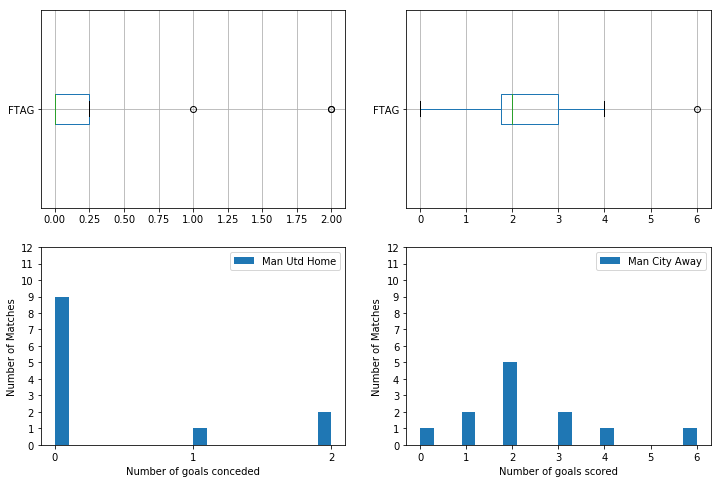

In [40]:
obj = []
obj.append(PlotObject(teams["ManUnitedHome"], "FTAG", "Man Utd Home", "Number of goals conceded", "Number of Matches", [221,223]))
obj.append(PlotObject(teams["ManCityAway"], "FTAG", "Man City Away", "Number of goals scored", "Number of Matches", [222,224]))
plotstats(obj)

### Manchester City's home defence vs Manchester United's away offence

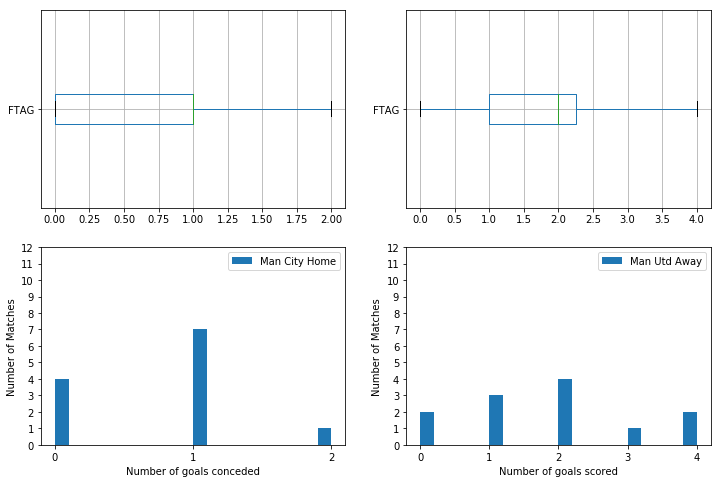

In [41]:
obj = []
obj.append(PlotObject(teams["ManCityHome"], "FTAG", "Man City Home", "Number of goals conceded", "Number of Matches", [221, 223]))
obj.append(PlotObject(teams["ManUnitedAway"], "FTAG", "Man Utd Away", "Number of goals scored", "Number of Matches", [222, 224]))
plotstats(obj)

## Simulation

To simulate the future matches, we can use the poisson distribution to randomly generate future scores and see how the teams stack up against eachother.

In [42]:
def sim_poisson(nums, mean):
    gen = np.random.poisson(lam = mean, size = nums)
    return gen

And then we can use this function to generate some scores for the following cases:
Man Utd Home vs Man City Away
Man City Home vs Man Utd Away

In [43]:
def generate_scores():
    gen_scores = []
    gen_scores.append(sim_poisson(1000, teams["ManUnitedHome"]["FTHG"].mean()))
    gen_scores.append(sim_poisson(1000, teams["ManUnitedAway"]["FTAG"].mean()))
    gen_scores.append(sim_poisson(1000, teams["ManCityHome"]["FTHG"].mean()))
    gen_scores.append(sim_poisson(1000, teams["ManCityAway"]["FTAG"].mean()))

    MUHVSMCA = list(map(list,zip(gen_scores[0],gen_scores[3])))
    MCHVSMUA = list(map(list,zip(gen_scores[2],gen_scores[1])))
    
    return {"ManUtdHvsMC": MUHVSMCA, "ManCityHvsMU": MCHVSMUA}

In [44]:
genscores = generate_scores()

We can summarise this data by looking at who won each game.

In [45]:
def getresult(arr):
    if arr[0] > arr[1]:
        return "H"
    elif arr[0] < arr[1]:
        return "A"
    else:
        return "D"

In [46]:
ManUtdHvsMC = [getresult(i) for i in (genscores["ManUtdHvsMC"])]

In [47]:
ManCityHvsMU = [getresult(i) for i in (genscores["ManCityHvsMU"])]

In [48]:
home_stats = {
    "MU Win": Counter(ManUtdHvsMC)["H"],
    "MC Win":  Counter(ManCityHvsMU)["H"],
}

In [49]:
away_stats = {
    "MU Win": Counter(ManCityHvsMU)["A"],
    "MC Win": Counter(ManUtdHvsMC)["A"],
}

In [50]:
draws = Counter(ManCityHvsMU)["D"] + Counter(ManUtdHvsMC)["D"]

In [51]:
df = pd.DataFrame(home_stats, index=["Home"])
df = df.append(pd.DataFrame(away_stats, index=["Away"]))
print("Total number of simulations: ",len(ManUtdHvsMC)+len(ManCityHvsMU))
print("\nWins/Losses simulated: \n",df)
print("\nTotal draws in simulation: ",Counter(ManUtdHvsMC)["D"] + Counter(ManCityHvsMU)["D"])

Total number of simulations:  2000

Wins/Losses simulated: 
       MC Win  MU Win
Home     699     414
Away     403     166

Total draws in simulation:  318


We can then find the probability of who will win the match based on the simulation from the fantasy games we've generated. In the most basic finding we can simply find out the probability of a team winning a match. For this we can use the following:

$$
P(ManUnitedWin) \\
P(ManCityWin)
$$

To do this we can design a function as follows:

In [52]:
def findoverallprob(team):
    total_matches = len(ManUtdHvsMC) + len(ManCityHvsMU)
    if team == "MU":
        team_win = home_stats["MU Win"] + away_stats["MU Win"]
    elif team == "MC":
        team_win = home_stats["MC Win"] + away_stats["MC Win"]
    elif team == "D":
        team_win = draws
    return team_win/float(total_matches)

From this we can observe the following results:

In [53]:
print("Probablity of Manchester United winning: ", findoverallprob("MU"))
print("Probablity of Manchester City winning: ", findoverallprob("MC"))
print("Probability of drawing: ", findoverallprob("D"))

Probablity of Manchester United winning:  0.29
Probablity of Manchester City winning:  0.551
Probability of drawing:  0.159


Here we can see that Manchester City has a much larger chance of winning the game based on the simulations we've done and even looking at the data from the premier league it is obvious that Manchester City was the better team. However, to break down these results we can also observe the following probabilities to give us a better outlook into the chances of winning for each team:

$$
P(ManUnitedWin \mid Home) \\
P(ManUnitedWin \mid Away) \\
P(ManCityWin \mid Home) \\
P(ManCityWin \mid Away)
$$


In [54]:
def findprob(team, side):
    if side == "home":
        if team == "MU":
            total_matches = home_stats["MU Win"] + away_stats["MC Win"]
            return home_stats["MU Win"]/float(total_matches)
        elif team == "MC":
            total_matches = home_stats["MC Win"] + away_stats["MU Win"]
            return home_stats["MC Win"]/float(total_matches)
    elif side == "away":
        if team == "MU":
            total_matches = away_stats["MU Win"] + home_stats["MC Win"]
            return away_stats["MU Win"]/float(total_matches)
        elif team == "MC":
            total_matches = away_stats["MC Win"] + home_stats["MU Win"]
            return away_stats["MC Win"]/float(total_matches)

And we can see the following probabilities from this:

In [55]:
print("Probability of MU win given they play home: ", findprob("MU", "home"))
print("Probability of MC win given they play home: ", findprob("MC", "home"))
print("Probability of MU win given they play away: ", findprob("MU", "away"))
print("Probability of MC win given they play away: ", findprob("MC", "away"))

Probability of MU win given they play home:  0.5067319461444308
Probability of MC win given they play home:  0.8080924855491329
Probability of MU win given they play away:  0.19190751445086704
Probability of MC win given they play away:  0.49326805385556916


From this we can observe that Manchester City has a higher chance of winning both playing home or away compared to Manchester United. From this we can confidently predict that in a match up of Manchester United vs Manchester City in the Premier League, based on the historical data; Manchester City will win the game. 